# Logs

In [1]:
from jyquickhelper import add_notebook_menu

add_notebook_menu(menu_id="main_menu")

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

## Load data

In [3]:
import pandas


def load_txt_file(filenames):
    if isinstance(filenames, str):
        filenames = [filenames]
    lines = []
    for filename in filenames:
        with open(filename, "r") as f:
            text = f.read()
        for t in text.split("\n"):
            if "{" not in t:
                continue
            r = eval(t)
            r["ort"] = "ORTModule" if "ort" in r["scenario"] else "torch"
            r["experiment"] = "-".join(
                c for c in r["scenario"].split("-") if c != "ort"
            )
            update = {}
            for k in r:
                if isinstance(k, tuple):
                    if len(k) == 2:
                        update[f"params-{k[0]}-{k[1]}"] = r[k]
                    elif len(k) == 3 and k[-1] == "grad":
                        update[f"grad-{k[0]}-{k[1]}"] = r[k]
            r.update(update)
            lines.append(r)
    df = pandas.DataFrame(lines)
    return df


df = load_txt_file("../log/results.txt")
columns = [c for c in df.columns if "(" not in str(c)]
columns_ = [c for c in df.columns if "(" in str(c)]
df[columns].head(n=2)

,get_rank,memory_cpu_percent,gpu_used_gb,local_rank,scenario,N,train_batch_size,time_per_img,time_per_iter,times,program,ort,experiment,params-torch.float32-cuda:0,grad-torch.float32-cuda:0,params-torch.float16-cuda:0
0,-1,2.7,5.395508,0,torch,100,8,0.052485,5.248508,"[5.24077152000973, 5.239782813005149, 5.264970...",perf.py,torch,torch,124443653.0,124443653.0,NaN
1,-1,2.8,5.081055,0,ort-torch,100,8,0.042093,4.209264,"[4.21380223199958, 4.208045980980387, 4.205944...",perf.py,ORTModule,torch,124443653.0,124443653.0,NaN


In [4]:
df.columns

Index([        ('torch.float32', 'cuda:0'),
       ('torch.float32', 'cuda:0', 'grad'),
                                'get_rank',
                      'memory_cpu_percent',
                             'gpu_used_gb',
                              'local_rank',
                                'scenario',
                                       'N',
                        'train_batch_size',
                            'time_per_img',
                           'time_per_iter',
                                   'times',
                                 'program',
                                     'ort',
                              'experiment',
             'params-torch.float32-cuda:0',
               'grad-torch.float32-cuda:0',
               ('torch.float16', 'cuda:0'),
             'params-torch.float16-cuda:0'],
      dtype='object')

In [5]:
df[columns_].head().T

C:\Python3105_x64\lib\site-packages\pandas\core\common.py:245: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = np.asarray(values, dtype=dtype)


,0,1,2,3,4
"(torch.float32, cuda:0)",124443653.0,124443653.0,124443653.0,124443653.0,NaN
"(torch.float32, cuda:0, grad)",124443653.0,124443653.0,NaN,NaN,NaN
"(torch.float16, cuda:0)",NaN,NaN,NaN,NaN,124443653.0


## results.txt

In [6]:
sel = df[["experiment", "ort", "time_per_img"]]
sel.sort_values(by=["experiment", "ort"]).head()

,experiment,ort,time_per_img
3,ds0,ORTModule,0.047516
2,ds0,torch,0.056867
5,ds0-f16,ORTModule,0.045870
4,ds0-f16,torch,0.061722
19,ds1,ORTModule,0.079318


### Time per image

In [7]:
piv = sel.pivot(index="experiment", columns="ort", values="time_per_img")
piv = piv.sort_values(by="torch")
piv["ort/ds"] = piv["ORTModule"] / piv["torch"]
piv

ort,ORTModule,torch,ort/ds
experiment,,,
torch,0.042093,0.052485,0.801992
ds0,0.047516,0.056867,0.835557
ds0-f16,0.045870,0.061722,0.743172
ds1-f16,0.062570,0.079094,0.791085
ds1,0.079318,0.092122,0.861013
ds1-f16-offload,0.253863,0.266747,0.951701
ds2-offload,0.262808,0.269847,0.973916
ds2,0.258382,0.273663,0.944160
ds2-f16-offload,0.251014,0.274353,0.914928


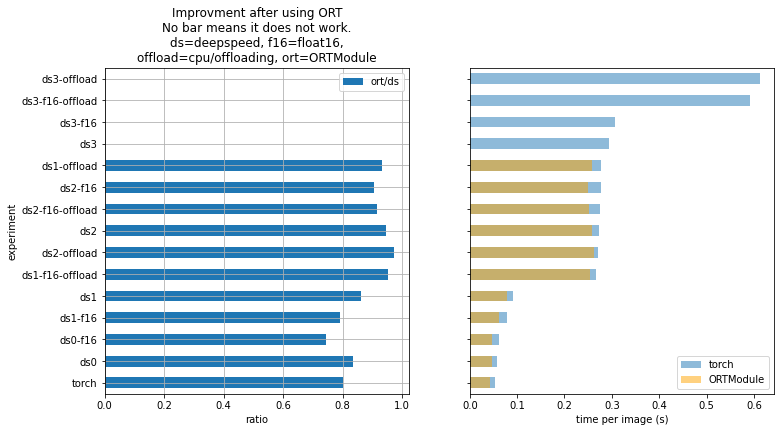

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6), sharey=True)
piv["ort/ds"].plot(
    kind="barh",
    grid=True,
    ax=ax[0],
    title="Improvment after using ORT\nNo bar means it does not work."
    "\nds=deepspeed, f16=float16,\noffload=cpu/offloading, ort=ORTModule",
)
piv["torch"].plot(ax=ax[1], kind="barh", alpha=0.5)
piv["ORTModule"].plot(ax=ax[1], kind="barh", color="orange", alpha=0.5)
ax[0].set_xlabel("ratio")
ax[1].set_xlabel("time per image (s)")
ax[0].legend()
ax[1].legend();

### Other metrics

In [9]:
piv = df.pivot(index="experiment", columns="ort", values="memory_cpu_percent")
piv = piv.sort_index()
piv["ort/ds"] = piv["ORTModule"] / piv["torch"]
piv

ort,ORTModule,torch,ort/ds
experiment,,,
ds0,2.8,2.8,1.000000
ds0-f16,2.8,2.8,1.000000
ds1,2.9,2.8,1.035714
ds1-f16,2.8,2.8,1.000000
ds1-f16-offload,3.6,3.5,1.028571
ds1-offload,3.6,3.6,1.000000
ds2,3.6,3.6,1.000000
ds2-f16,3.6,3.5,1.028571
ds2-f16-offload,3.5,3.5,1.000000


In [10]:
piv = df.pivot(index="experiment", columns="ort", values="gpu_used_gb")
piv = piv.sort_index()
piv["ort/ds"] = piv["ORTModule"] / piv["torch"]
piv

ort,ORTModule,torch,ort/ds
experiment,,,
ds0,5.008789,5.508789,0.909236
ds0-f16,4.493164,4.723633,0.951209
ds1,6.434570,6.211914,1.035843
ds1-f16,4.795898,4.475586,1.071569
ds1-f16-offload,3.079102,3.157227,0.975255
ds1-offload,5.024414,5.260742,0.955077
ds2,6.518555,6.446289,1.011210
ds2-f16,3.827148,3.922852,0.975604
ds2-f16-offload,3.827148,3.922852,0.975604


### Parameters size

The figures for DeepSpeed stage 3 are interesting. It comes from the following code which aggregates the number of parameters per dtype and device. This sum is almost zero with deepspeed stage 3. Parameter size are null.

```python
params = list(model.parameters())
for p in params:
    key = str(p.dtype), str(p.device)
    if key not in kinds:
        stats[key] = 0
    stats[key] += np.prod(tuple(p.shape))
```

In [11]:
piv = pandas.pivot_table(
    df,
    index="experiment",
    columns="ort",
    values=["params-torch.float32-cuda:0", "grad-torch.float32-cuda:0"],
)
piv = piv.sort_index()
piv

grad-torch.float32-cuda:0               \
ort                         ORTModule        torch   
experiment                                           
ds0                               NaN          NaN   
ds1                               NaN          NaN   
ds1-offload                       NaN          NaN   
ds2                               NaN          NaN   
ds2-offload                       NaN          NaN   
ds3                               NaN          NaN   
ds3-offload                       NaN          NaN   
torch                     124443653.0  124443653.0   

            params-torch.float32-cuda:0               
ort                           ORTModule        torch  
experiment                                            
ds0                         124443653.0  124443653.0  
ds1                         124443653.0  124443653.0  
ds1-offload                 124443653.0  124443653.0  
ds2                         124443653.0  124443653.0  
ds2-offload                 124443653.0  124443653.0  
ds3                                 NaN     125189.0  
ds3-offload                         NaN     125189.0  
torch                       124443653.0  124443653.0

In [12]:
piv = pandas.pivot_table(
    df, index="experiment", columns="ort", values=["params-torch.float16-cuda:0"]
)  # , "grad-torch.float16-cuda:0"])
piv = piv.sort_index()
piv

params-torch.float16-cuda:0             
ort                               ORTModule        torch
experiment                                              
ds0-f16                         124443653.0  124443653.0
ds1-f16                         124443653.0  124443653.0
ds1-f16-offload                 124443653.0  124443653.0
ds2-f16                         124443653.0  124443653.0
ds2-f16-offload                 124443653.0  124443653.0
ds3-f16                                 NaN     125189.0
ds3-f16-offload                         NaN     125189.0

## log-distri.txt - distributed

In [13]:
dfl = load_txt_file([f"../log/log-distri-gpt2-{i}.txt" for i in range(4)])
dfl_large = load_txt_file([f"../log/log-distri-gpt2-large-{i}.txt" for i in range(4)])
dfl.shape, dfl_large.shape

((96, 27), (64, 27))

In [14]:
columns = [c for c in dfl.columns if "(" not in str(c)]
columns_ = [c for c in dfl.columns if "(" in str(c)]
dfl[columns].head(n=2)

,WORLD_SIZE,N,time,time_per_img,get_rank,memory_cpu_percent,gpu_used_gb,local_rank,scenario,ort,experiment,params-torch.float32-cuda:0,params-torch.float16-cuda:0,params-torch.float32-cuda:1,params-torch.float16-cuda:1,params-torch.float32-cuda:2,params-torch.float16-cuda:2,params-torch.float32-cuda:3,params-torch.float16-cuda:3
0,4,48,10.926279,0.232474,0,4.1,3.532227,0,ds0,torch,ds0,124443653.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,4,48,12.878813,0.274017,0,4.2,4.235352,0,ds1,torch,ds1,124443653.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Time per image on one GPU

Two models:

* gpt2: 500 Mb (499.053.592 b)
* gpt2-large: 3 Gb (3.014.423 Kb)

In [15]:
piv = dfl[dfl.local_rank == 0].pivot_table(
    index="experiment", columns="ort", values="time_per_img"
)
piv = piv.sort_values(by="torch")
piv["ort/ds"] = piv["ORTModule"] / piv["torch"]
piv

ort,ORTModule,torch,ort/ds
experiment,,,
ds0-f16,0.116656,0.132604,0.879726
ds1-f16,0.136848,0.155789,0.878423
ds1-f16-offload,0.188014,0.206713,0.909539
ds2-f16,0.185453,0.215175,0.861873
ds2-f16-offload,0.186759,0.218402,0.855117
ds0,0.224268,0.232474,0.964703
ds2,0.319974,0.234231,1.366061
ds1,0.206592,0.274017,0.753939
ds1-offload,0.331085,0.288508,1.147579


In [16]:
piv_large = dfl_large[dfl_large.local_rank == 1].pivot_table(
    index="experiment", columns="ort", values="time_per_img"
)
piv_large = piv_large.sort_values(by="torch")
piv_large["ort/ds"] = piv_large["ORTModule"] / piv_large["torch"]
piv_large

ort,ORTModule,torch,ort/ds
experiment,,,
ds1-f16,0.568605,0.655975,0.866810
ds1-f16-offload,1.135861,1.203729,0.943618
ds2-f16-offload,1.048813,1.223519,0.857210
ds2-f16,1.041897,1.232720,0.845202
ds3-f16,NaN,1.797093,NaN
ds3-f16-offload,NaN,2.539883,NaN
ds1-offload,2.210429,NaN,NaN
ds2-offload,2.111918,NaN,NaN


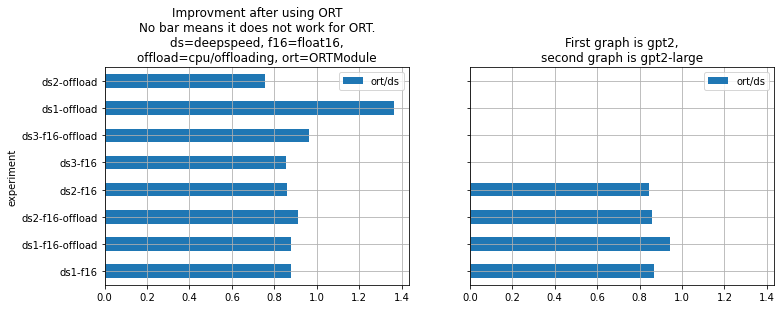

In [17]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(12, 4), sharey=True, sharex=True)
piv["ort/ds"].plot(
    kind="barh",
    grid=True,
    ax=ax[0],
    title="Improvment after using ORT\nNo bar means it does not work for ORT."
    "\nds=deepspeed, f16=float16,\noffload=cpu/offloading, ort=ORTModule",
)
piv_large["ort/ds"].plot(
    kind="barh",
    grid=True,
    ax=ax[1],
    title="First graph is gpt2,\nsecond graph is gpt2-large",
)
ax[0].legend()
ax[1].legend();

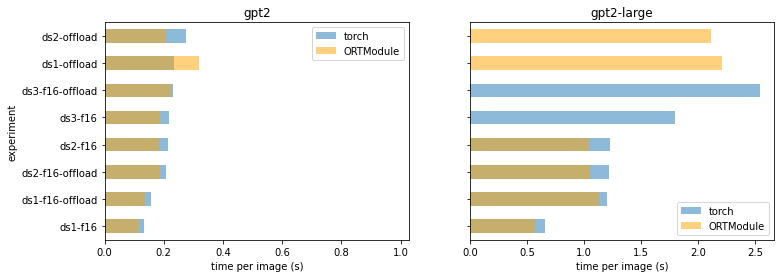

In [18]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4), sharey=True)
piv["torch"].plot(ax=ax[0], kind="barh", alpha=0.5, title="gpt2")
piv["ORTModule"].plot(ax=ax[0], kind="barh", color="orange", alpha=0.5)
piv_large["torch"].plot(ax=ax[1], kind="barh", alpha=0.5, title="gpt2-large")
piv_large["ORTModule"].plot(ax=ax[1], kind="barh", color="orange", alpha=0.5)
ax[0].set_xlabel("time per image (s)")
ax[1].set_xlabel("time per image (s)")
ax[0].legend()
ax[1].legend();

### Other metrics

#### memory_cpu_percent

In [19]:
piv = pandas.pivot_table(
    dfl, index="experiment", columns="ort", values="memory_cpu_percent"
)
piv = piv.sort_index()
piv_large["ort/ds"] = piv_large["ORTModule"] / piv_large["torch"]
piv

ort,ORTModule,torch
experiment,,
ds0,4.35,4.1
ds0-f16,4.40,4.1
ds1,4.50,4.2
ds1-f16,4.50,4.2
ds1-f16-offload,5.90,5.7
ds1-offload,6.10,6.0
ds2,6.10,6.0
ds2-f16,5.90,5.8
ds2-f16-offload,5.90,5.8


In [20]:
piv = pandas.pivot_table(
    dfl_large, index="experiment", columns="ort", values="memory_cpu_percent"
)
piv = piv.sort_index()
piv_large["ort/ds"] = piv_large["ORTModule"] / piv_large["torch"]
piv

ort,ORTModule,torch
experiment,,
ds1-f16,3.9,4.2
ds1-f16-offload,7.8,8.7
ds1-offload,9.5,NaN
ds2-f16,7.8,9.3
ds2-f16-offload,7.8,8.7
ds2-offload,9.5,NaN
ds3-f16,NaN,4.2
ds3-f16-offload,NaN,8.3


#### gpu_used_gb

In [21]:
piv = pandas.pivot_table(dfl, index="experiment", columns="ort", values="gpu_used_gb")
piv = piv.sort_index()
piv_large["ort/ds"] = piv_large["ORTModule"] / piv_large["torch"]
piv

ort,ORTModule,torch
experiment,,
ds0,3.555664,3.532227
ds0-f16,3.614258,3.916992
ds1,3.891602,4.293945
ds1-f16,2.629883,2.579102
ds1-f16-offload,2.399902,2.483887
ds1-offload,3.852051,4.119629
ds2,4.619141,4.855469
ds2-f16,2.802246,2.893555
ds2-f16-offload,2.802246,2.893555


In [22]:
piv = pandas.pivot_table(
    dfl_large, index="experiment", columns="ort", values="gpu_used_gb"
)
piv = piv.sort_index()
piv_large["ort/ds"] = piv_large["ORTModule"] / piv_large["torch"]
piv

ort,ORTModule,torch
experiment,,
ds1-f16,7.598145,8.260742
ds1-f16-offload,5.259766,6.130859
ds1-offload,13.741699,NaN
ds2-f16,5.690430,6.569824
ds2-f16-offload,5.690430,6.569824
ds2-offload,14.069824,NaN
ds3-f16,NaN,7.851562
ds3-f16-offload,NaN,5.163086


#### params-torch.float32-cuda:0

In [23]:
piv = pandas.pivot_table(
    dfl, index="experiment", columns="ort", values="params-torch.float32-cuda:0"
)
piv = piv.sort_index()
piv_large["ort/ds"] = piv_large["ORTModule"] / piv_large["torch"]
piv

ort,ORTModule,torch
experiment,,
ds0,124443653.0,124443653.0
ds1,124443653.0,124443653.0
ds1-offload,124443653.0,124443653.0
ds2,124443653.0,124443653.0
ds2-offload,124443653.0,124443653.0
ds3,NaN,125189.0
ds3-offload,NaN,125189.0


In [24]:
piv = pandas.pivot_table(
    dfl, index="experiment", columns="ort", values="params-torch.float16-cuda:0"
)
piv = piv.sort_index()
piv_large["ort/ds"] = piv_large["ORTModule"] / piv_large["torch"]
piv

ort,ORTModule,torch
experiment,,
ds0-f16,124443653.0,124443653.0
ds1-f16,124443653.0,124443653.0
ds1-f16-offload,124443653.0,124443653.0
ds2-f16,124443653.0,124443653.0
ds2-f16-offload,124443653.0,124443653.0
ds3-f16,NaN,0.0
ds3-f16-offload,NaN,0.0


In [25]:
piv = pandas.pivot_table(
    dfl_large, index="experiment", columns="ort", values="params-torch.float16-cuda:0"
)
piv = piv.sort_index()
piv_large["ort/ds"] = piv_large["ORTModule"] / piv_large["torch"]
piv

ort,ORTModule,torch
experiment,,
ds1-f16,774036485.0,774036485.0
ds1-f16-offload,774036485.0,774036485.0
ds2-f16,774036485.0,774036485.0
ds2-f16-offload,774036485.0,774036485.0
ds3-f16,NaN,0.0
ds3-f16-offload,NaN,0.0
